In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

import math
import random
from typing import List
from PIL import Image

# Задание 1

In [ ]:
class Layer:
    """
    Базовый класс для всех слоёв нейросети.

    Содержит флаг режима работы:
    - training = True  → режим обучения (train)
    - training = False → режим инференса (eval)

    Методы:
    --------
    train():
        Переключает слой в режим обучения.

    eval():
        Переключает слой в режим инференса.

    forward(x):
        Прямой проход (должен быть реализован в дочерних классах).

    backward(dout):
        Обратное распространение градиента.
    """
    def __init__(self):
        self.training = True

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def forward(self, x):
        raise NotImplementedError

    def backward(self, dout):
        raise NotImplementedError


In [ ]:
class BatchNorm(Layer):
    """
    Batch Normalization слой (аналог nn.BatchNorm1d).

    Идея:
    -----
    Нормализует признаки по batch:
        x̂ = (x - mean) / sqrt(var + eps)
        y = gamma * x̂ + beta

    Режимы:
    -------
    train:
        - mean и var считаются по текущему batch
        - обновляются running_mean и running_var

    eval:
        - используются running_mean и running_var

    Размерности:
    ------------
    x : (batch_size, num_features)
    """

    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        super().__init__()
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        self.gamma.grad = torch.zeros_like(self.gamma)
        self.beta.grad = torch.zeros_like(self.beta)

        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

        self.eps = eps
        self.momentum = momentum

    def forward(self, x):
        self.x = x

        if self.training:
            self.mean = x.mean(dim=0)
            self.var = x.var(dim=0, unbiased=False)

            self.running_mean = (
                self.momentum * self.running_mean
                + (1 - self.momentum) * self.mean
            )
            self.running_var = (
                self.momentum * self.running_var
                + (1 - self.momentum) * self.var
            )
        else:
            self.mean = self.running_mean
            self.var = self.running_var

        self.x_hat = (x - self.mean) / torch.sqrt(self.var + self.eps)
        return self.gamma * self.x_hat + self.beta

    def backward(self, dout):
        if not self.training:
            return dout * self.gamma / torch.sqrt(self.var + self.eps)

        N = dout.shape[0]

        self.gamma.grad += (dout * self.x_hat).sum(dim=0)
        self.beta.grad += dout.sum(dim=0)

        dx_hat = dout * self.gamma
        dvar = (-0.5 * dx_hat * self.x_hat).sum(dim=0) / (self.var + self.eps)
        dmean = (-dx_hat / torch.sqrt(self.var + self.eps)).sum(dim=0)

        dx = (
            dx_hat / torch.sqrt(self.var + self.eps)
            + dvar * 2 * self.x_hat / N
            + dmean / N
        )
        return dx


In [ ]:
class Linear(Layer):
    """
    Полносвязный (линейный) слой.

    Математика:
    -----------
    y = x @ W^T + b

    Размерности:
    ------------
    x : (batch_size, in_features)
    W : (out_features, in_features)
    b : (out_features,)
    y : (batch_size, out_features)

    Особенности:
    ------------
    - Одинаково работает в режимах train и eval
    - Хранит параметры W и b и их градиенты
    """

    def __init__(self, in_features, out_features):
        super().__init__()
        self.W = torch.randn(out_features, in_features) * math.sqrt(2 / in_features)
        self.b = torch.zeros(out_features)

        self.W.grad = torch.zeros_like(self.W)
        self.b.grad = torch.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return x @ self.W.T + self.b

    def backward(self, dout):
        self.W.grad += dout.T @ self.x
        self.b.grad += dout.sum(dim=0)
        return dout @ self.W


In [ ]:
class Dropout(Layer):
    """
    Dropout слой.

    Идея:
    -----
    Случайно зануляет элементы входа с вероятностью p
    для борьбы с переобучением.

    Режимы:
    -------
    train:
        - применяется случайная маска
        - масштабирование на 1 / (1 - p)

    eval:
        - слой ничего не делает

    Размерности:
    ------------
    Работает с тензорами любой формы
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training:
            return x

        self.mask = (torch.rand_like(x) > self.p).float()
        return x * self.mask / (1 - self.p)

    def backward(self, dout):
        if not self.training:
            return dout
        return dout * self.mask / (1 - self.p)


In [ ]:
class ReLU(Layer):
    """
    ReLU (Rectified Linear Unit).

    Математика:
    -----------
    y = max(0, x)

    Свойства:
    ---------
    - Обнуляет отрицательные значения
    - Не имеет параметров
    - Одинаково работает в train и eval
    """

    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask


In [ ]:
class Sigmoid(Layer):
    """
    Sigmoid функция активации.

    Математика:
    -----------
    σ(x) = 1 / (1 + exp(-x))

    Свойства:
    ---------
    - Сжимает значения в диапазон (0, 1)
    - Часто используется в бинарной классификации
    """

    def forward(self, x):
        self.out = 1 / (1 + torch.exp(-x))
        return self.out

    def backward(self, dout):
        return dout * self.out * (1 - self.out)


In [ ]:
class Softmax(Layer):
    """
    Softmax слой.

    Математика:
    -----------
    softmax(x_i) = exp(x_i) / sum_j exp(x_j)

    Особенности:
    ------------
    - Применяется по последнему измерению (классы)
    - Обычно используется вместе с CrossEntropyLoss
    - Здесь реализован полный backward через якобиан
    """

    def forward(self, x):
        x = x - x.max(dim=1, keepdim=True).values
        exp_x = torch.exp(x)
        self.out = exp_x / exp_x.sum(dim=1, keepdim=True)
        return self.out

    def backward(self, dout):
        dx = torch.zeros_like(dout)
        for i in range(dout.shape[0]):
            y = self.out[i].unsqueeze(1)
            jacobian = torch.diagflat(y) - y @ y.T
            dx[i] = dout[i] @ jacobian
        return dx


# Задание 2

In [ ]:
def median_filter(img: torch.Tensor, k: int) -> torch.Tensor:
    """
    img: Tensor (H, W)
    k: размер ядра (k x k)
    """
    H, W = img.shape
    pad = k // 2

    # отражающий padding вручную
    padded = torch.zeros((H + 2*pad, W + 2*pad))
    padded[pad:pad+H, pad:pad+W] = img

    # отражение по вертикали
    padded[:pad, pad:pad+W] = img[1:pad+1].flip(0)
    padded[pad+H:, pad:pad+W] = img[-pad-1:-1].flip(0)

    # отражение по горизонтали
    padded[:, :pad] = padded[:, pad:2*pad].flip(1)
    padded[:, pad+W:] = padded[:, W:W+pad].flip(1)

    # выход
    out = torch.zeros_like(img)

    # основной цикл
    for i in range(H):
        for j in range(W):
            window = padded[i:i+k, j:j+k]
            out[i, j] = window.flatten().median()

    return out


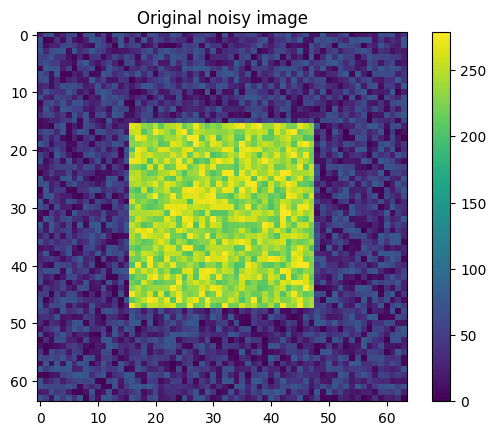

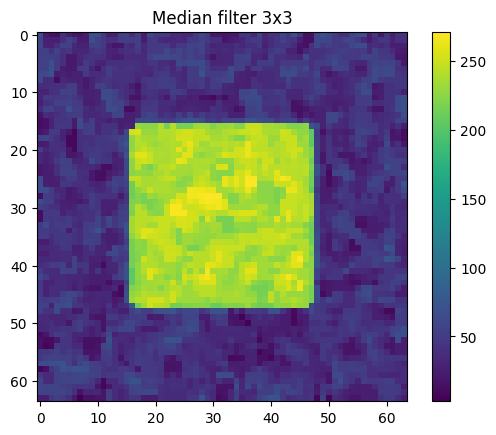

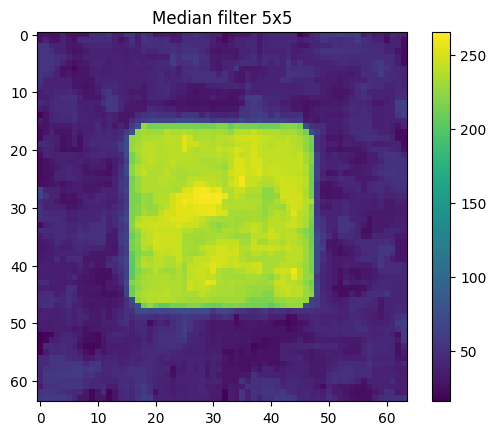

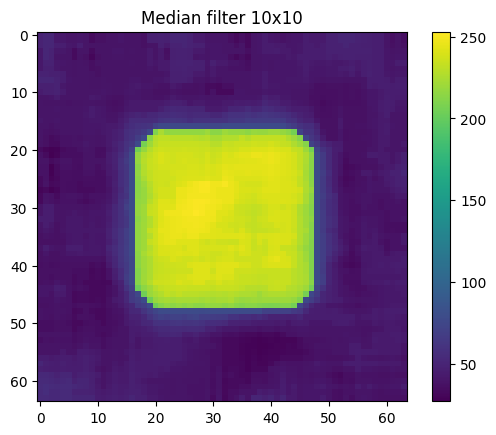

In [ ]:
torch.manual_seed(42)

H, W = 64, 64
img = torch.zeros((H, W))
img[16:48, 16:48] = 200
img += torch.randint(0, 80, (H, W)).float()


# --- show original ---
plt.figure()
plt.imshow(img)
plt.title("Original noisy image")
plt.colorbar()
plt.show()


# --- show median filters with different kernel sizes ---
for k in [3, 5, 10]:
    filtered = median_filter(img, k)

    plt.figure()
    plt.imshow(filtered)
    plt.title(f"Median filter {k}x{k}")
    plt.colorbar()
    plt.show()


# Задание 3

In [2]:
class BaseTransform:
    def __init__(self, p: float):
        assert 0.0 <= p <= 1.0, "p должно быть в диапазоне [0, 1]"
        self.p = p

    def should_apply(self) -> bool:
        return random.random() < self.p

    def __call__(self, img: Image.Image) -> Image.Image:
        raise NotImplementedError

In [3]:
class RandomCrop(BaseTransform):
    def __init__(self, p: float, size: tuple[int, int]):
        super().__init__(p)
        self.crop_h, self.crop_w = size

    def __call__(self, img: Image.Image) -> Image.Image:
        if not self.should_apply():
            return img

        w, h = img.size
        ch, cw = self.crop_h, self.crop_w

        # граничный случай
        if cw > w or ch > h:
            return img

        left = random.randint(0, w - cw)
        top = random.randint(0, h - ch)

        return img.crop((left, top, left + cw, top + ch))

In [4]:
class RandomRotate(BaseTransform):
    def __init__(self, p: float, degrees: float):
        super().__init__(p)
        self.degrees = degrees

    def __call__(self, img: Image.Image) -> Image.Image:
        if not self.should_apply():
            return img

        angle = random.uniform(-self.degrees, self.degrees)
        return img.rotate(angle)


In [5]:
class RandomZoom(BaseTransform):
    def __init__(self, p: float, scale_range: tuple[float, float]):
        super().__init__(p)
        self.min_scale, self.max_scale = scale_range

    def __call__(self, img: Image.Image) -> Image.Image:
        if not self.should_apply():
            return img

        scale = random.uniform(self.min_scale, self.max_scale)
        w, h = img.size
        new_w, new_h = int(w * scale), int(h * scale)

        resized = img.resize((new_w, new_h), Image.BILINEAR)

        # центрируем обратно к исходному размеру
        if scale >= 1.0:
            left = (new_w - w) // 2
            top = (new_h - h) // 2
            return resized.crop((left, top, left + w, top + h))
        else:
            canvas = Image.new(img.mode, (w, h))
            left = (w - new_w) // 2
            top = (h - new_h) // 2
            canvas.paste(resized, (left, top))
            return canvas


In [6]:
class ToTensor:
    def __call__(self, img: Image.Image) -> torch.Tensor:
        arr = np.array(img, dtype=np.float32) / 255.0

        if arr.ndim == 2:
            arr = arr[:, :, None]

        # HWC → CHW
        arr = arr.transpose(2, 0, 1)
        return torch.from_numpy(arr)


In [7]:
class Compose:
    def __init__(self, transforms: List[BaseTransform]):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img


In [8]:
img = Image.new("RGB", (100, 100), color="red")

In [9]:
random.seed(42)

transform = Compose([
    RandomCrop(p=1.0, size=(50, 50)),
    RandomRotate(p=1.0, degrees=30),
    RandomZoom(p=1.0, scale_range=(0.8, 1.2)),
])

img1 = transform(img)
random.seed(42)
img2 = transform(img)

assert list(img1.getdata()) == list(img2.getdata())
print("Воспроизводимость: OK")


Воспроизводимость: OK


In [10]:
transform = RandomRotate(p=0.0, degrees=90)
out = transform(img)

assert list(out.getdata()) == list(img.getdata())
print("p = 0: OK")

p = 0: OK


In [11]:
tensor = ToTensor()(img)
print(tensor.shape)  # (3, 100, 100)
assert isinstance(tensor, torch.Tensor)
print("ToTensor: OK")

torch.Size([3, 100, 100])
ToTensor: OK


In [12]:
crop = RandomCrop(p=1.0, size=(200, 200))
out = crop(img)

assert out.size == img.size
print("Crop > image: OK")

Crop > image: OK


# Задание 4

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST

In [14]:
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, base, transform):
        self.base = base
        self.transform = transform

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, y = self.base[idx]
        return self.transform(img), y

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.net(x)


In [16]:
def train_eval(train_loader, test_loader, epochs=15, device="cpu"):
    model = SimpleCNN().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_loss, test_loss = [], []
    train_acc, test_acc = [], []

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * x.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss.append(loss_sum / total)
        train_acc.append(correct / total)

        # ===== EVAL =====
        model.eval()
        total, correct, loss_sum = 0, 0, 0.0

        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)

                logits = model(x)
                loss = criterion(logits, y)

                loss_sum += loss.item() * x.size(0)
                correct += (logits.argmax(1) == y).sum().item()
                total += y.size(0)

        test_loss.append(loss_sum / total)
        test_acc.append(correct / total)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train loss: {train_loss[-1]:.4f}, acc: {train_acc[-1]:.4f} | "
            f"Test loss: {test_loss[-1]:.4f}, acc: {test_acc[-1]:.4f}"
        )

    return train_loss, test_loss, train_acc, test_acc


In [17]:
train_base = FashionMNIST("./data", train=True, download=True)
test_base = FashionMNIST("./data", train=False, download=True)

In [18]:
plain_tf = Compose([
    ToTensor()
])

moderate_tf = Compose([
    RandomRotate(p=0.5, degrees=20),
    RandomZoom(p=0.5, scale_range=(0.9, 1.1)),
    ToTensor()
])

strong_tf = Compose([
    RandomRotate(p=0.9, degrees=45),
    RandomZoom(p=0.9, scale_range=(0.7, 1.3)),
    RandomCrop(p=0.7, size=(28, 28)),
    ToTensor()
])

In [19]:
train_plain = TransformedDataset(train_base, plain_tf)
train_moderate = TransformedDataset(train_base, moderate_tf)
train_strong = TransformedDataset(train_base, strong_tf)

test_ds = TransformedDataset(test_base, plain_tf)

In [20]:
train_plain_loader = DataLoader(train_plain, batch_size=128, shuffle=True)
train_moderate_loader = DataLoader(train_moderate, batch_size=128, shuffle=True)
train_strong_loader = DataLoader(train_strong, batch_size=128, shuffle=True)

test_loader = DataLoader(test_ds, batch_size=256)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
plain_res = train_eval(train_plain_loader, test_loader, epochs=15, device=device)
moderate_res = train_eval(train_moderate_loader, test_loader, epochs=15, device=device)
strong_res = train_eval(train_strong_loader, test_loader, epochs=15, device=device)

Epoch [1/15] | Train loss: 0.5261, acc: 0.8100 | Test loss: 0.3647, acc: 0.8684
Epoch [2/15] | Train loss: 0.3234, acc: 0.8835 | Test loss: 0.3083, acc: 0.8890
Epoch [3/15] | Train loss: 0.2771, acc: 0.8985 | Test loss: 0.2914, acc: 0.8950
Epoch [4/15] | Train loss: 0.2442, acc: 0.9112 | Test loss: 0.2730, acc: 0.8996
Epoch [5/15] | Train loss: 0.2239, acc: 0.9187 | Test loss: 0.2634, acc: 0.9025
Epoch [6/15] | Train loss: 0.2034, acc: 0.9250 | Test loss: 0.2460, acc: 0.9116
Epoch [7/15] | Train loss: 0.1842, acc: 0.9323 | Test loss: 0.2455, acc: 0.9149
Epoch [8/15] | Train loss: 0.1703, acc: 0.9373 | Test loss: 0.2719, acc: 0.9019
Epoch [9/15] | Train loss: 0.1577, acc: 0.9417 | Test loss: 0.2355, acc: 0.9186
Epoch [10/15] | Train loss: 0.1426, acc: 0.9471 | Test loss: 0.2319, acc: 0.9200
Epoch [11/15] | Train loss: 0.1286, acc: 0.9526 | Test loss: 0.2402, acc: 0.9215
Epoch [12/15] | Train loss: 0.1171, acc: 0.9573 | Test loss: 0.2412, acc: 0.9187
Epoch [13/15] | Train loss: 0.1048, a

In [ ]:
epochs = range(1, len(plain_res[0]) + 1)

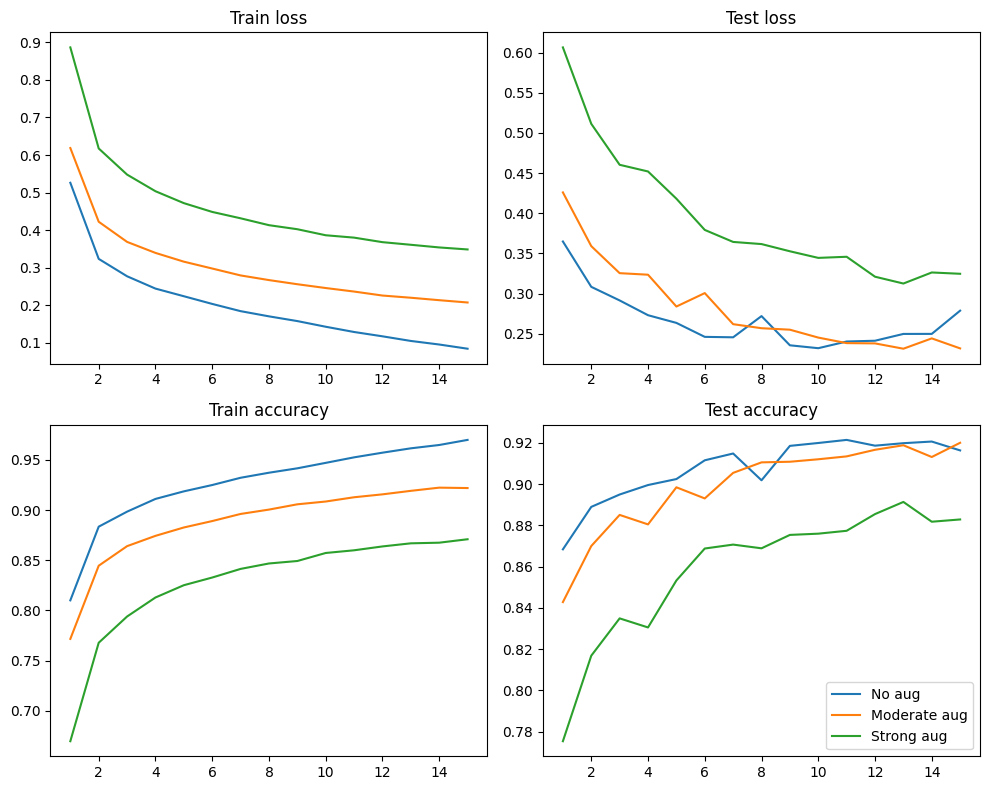

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(epochs, plain_res[0])
axs[0, 0].plot(epochs, moderate_res[0])
axs[0, 0].plot(epochs, strong_res[0])
axs[0, 0].set_title("Train loss")

axs[0, 1].plot(epochs, plain_res[1])
axs[0, 1].plot(epochs, moderate_res[1])
axs[0, 1].plot(epochs, strong_res[1])
axs[0, 1].set_title("Test loss")

axs[1, 0].plot(epochs, plain_res[2])
axs[1, 0].plot(epochs, moderate_res[2])
axs[1, 0].plot(epochs, strong_res[2])
axs[1, 0].set_title("Train accuracy")

axs[1, 1].plot(epochs, plain_res[3], label="No aug")
axs[1, 1].plot(epochs, moderate_res[3], label="Moderate aug")
axs[1, 1].plot(epochs, strong_res[3], label="Strong aug")
axs[1, 1].set_title("Test accuracy")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

Обучение без трансформаций приводит к быстрому переобучению модели: высокая точность на трейне не даёт наилучшего результата на тесте.
Использование умеренных трансформаций улучшает обобщающую способность модели и даёт наилучшую точность на тестовой выборке.
Сильные трансформации чрезмерно искажают данные, из-за чего модель недообучается и показывает худшие результаты.

Трансформации полезны, но наиболее эффективны при умеренном применении.

# Задание 5

In [22]:
!pip install wandb

In [23]:
import wandb

In [24]:
wandb.login()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nikitaosovskiy (nikitaosovskiy-saint-petersburg-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [25]:
wandb.init(
    project="fashion-mnist-augmentation",
    name="train_aug_experiments"
)

In [26]:
def train_eval_wandb(train_loader, test_loader, epochs=30, device="cpu", config=None):
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.get("lr", 1e-3))
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # ===== TRAIN =====
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = loss_sum / total
        train_acc = correct / total

        # ===== TEST =====
        model.eval()
        total, correct, loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = model(x)
                loss = criterion(out, y)

                loss_sum += loss.item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)

        test_loss = loss_sum / total
        test_acc = correct / total

        # ===== LOG TO WANDB =====
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_loss": test_loss,
            "test_acc": test_acc
        })

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
            f"Test loss: {test_loss:.4f}, acc: {test_acc:.4f}"
        )

    return model


In [31]:
config = {
    "lr": 1e-3,
    "batch_size": 128,
    "epochs": 15
}

In [34]:
def run_experiment(
    run_name,
    train_loader,
    test_loader,
    device,
    config,
    aug_type
):
    wandb.init(
        project="fashion-mnist-augmentation",
        name=run_name,
        config={
            **config,
            "augmentation": aug_type
        }
    )

    train_eval_wandb(
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=config["epochs"],
        device=device,
        config=config
    )

    wandb.finish()


In [35]:
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_experiment(
    run_name="no_augmentation",
    train_loader=train_plain_loader,
    test_loader=test_loader,
    device=device,
    config=config,
    aug_type="none"
)

run_experiment(
    run_name="moderate_augmentation",
    train_loader=train_moderate_loader,
    test_loader=test_loader,
    device=device,
    config=config,
    aug_type="moderate"
)

run_experiment(
    run_name="strong_augmentation",
    train_loader=train_strong_loader,
    test_loader=test_loader,
    device=device,
    config=config,
    aug_type="strong"
)


Epoch [1/15] | Train loss: 0.5038, acc: 0.8187 | Test loss: 0.4020, acc: 0.8520
Epoch [2/15] | Train loss: 0.3184, acc: 0.8853 | Test loss: 0.3089, acc: 0.8906
Epoch [3/15] | Train loss: 0.2735, acc: 0.9008 | Test loss: 0.3023, acc: 0.8900
Epoch [4/15] | Train loss: 0.2459, acc: 0.9105 | Test loss: 0.2668, acc: 0.9029
Epoch [5/15] | Train loss: 0.2239, acc: 0.9185 | Test loss: 0.2578, acc: 0.9091
Epoch [6/15] | Train loss: 0.2041, acc: 0.9252 | Test loss: 0.2507, acc: 0.9100
Epoch [7/15] | Train loss: 0.1867, acc: 0.9316 | Test loss: 0.2614, acc: 0.9084
Epoch [8/15] | Train loss: 0.1696, acc: 0.9373 | Test loss: 0.2434, acc: 0.9137
Epoch [9/15] | Train loss: 0.1561, acc: 0.9424 | Test loss: 0.2368, acc: 0.9225
Epoch [10/15] | Train loss: 0.1420, acc: 0.9472 | Test loss: 0.2476, acc: 0.9163
Epoch [11/15] | Train loss: 0.1287, acc: 0.9519 | Test loss: 0.2429, acc: 0.9196
Epoch [12/15] | Train loss: 0.1151, acc: 0.9573 | Test loss: 0.2488, acc: 0.9220
Epoch [13/15] | Train loss: 0.1040, a

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁▅▅▆▇▇▇▇█▇██▇██
test_loss,█▄▄▂▂▂▂▁▁▁▁▂▂▂▂
train_acc,▁▄▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
epoch,15
test_acc,0.9183
test_loss,0.27196
train_acc,0.9697
train_loss,0.08327


Epoch [1/15] | Train loss: 0.6063, acc: 0.7779 | Test loss: 0.4139, acc: 0.8514
Epoch [2/15] | Train loss: 0.4181, acc: 0.8449 | Test loss: 0.3555, acc: 0.8699
Epoch [3/15] | Train loss: 0.3663, acc: 0.8650 | Test loss: 0.3204, acc: 0.8862
Epoch [4/15] | Train loss: 0.3396, acc: 0.8740 | Test loss: 0.3199, acc: 0.8851
Epoch [5/15] | Train loss: 0.3133, acc: 0.8837 | Test loss: 0.2964, acc: 0.8960
Epoch [6/15] | Train loss: 0.2963, acc: 0.8892 | Test loss: 0.2800, acc: 0.8986
Epoch [7/15] | Train loss: 0.2807, acc: 0.8954 | Test loss: 0.2606, acc: 0.9069
Epoch [8/15] | Train loss: 0.2733, acc: 0.8974 | Test loss: 0.2626, acc: 0.9059
Epoch [9/15] | Train loss: 0.2560, acc: 0.9055 | Test loss: 0.2575, acc: 0.9059
Epoch [10/15] | Train loss: 0.2483, acc: 0.9076 | Test loss: 0.2571, acc: 0.9078
Epoch [11/15] | Train loss: 0.2356, acc: 0.9134 | Test loss: 0.2387, acc: 0.9148
Epoch [12/15] | Train loss: 0.2294, acc: 0.9137 | Test loss: 0.2492, acc: 0.9109
Epoch [13/15] | Train loss: 0.2228, a

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁▃▅▅▆▆▇▇▇▇█▇▇█▇
test_loss,█▆▄▄▃▃▂▂▂▂▁▂▁▁▂
train_acc,▁▄▅▆▆▆▇▇▇▇█████
train_loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch,15
test_acc,0.9139
test_loss,0.25651
train_acc,0.92122
train_loss,0.20919


Epoch [1/15] | Train loss: 0.8879, acc: 0.6666 | Test loss: 0.5935, acc: 0.7801
Epoch [2/15] | Train loss: 0.6141, acc: 0.7695 | Test loss: 0.4996, acc: 0.8203
Epoch [3/15] | Train loss: 0.5476, acc: 0.7953 | Test loss: 0.4757, acc: 0.8281
Epoch [4/15] | Train loss: 0.5039, acc: 0.8122 | Test loss: 0.4098, acc: 0.8537
Epoch [5/15] | Train loss: 0.4738, acc: 0.8230 | Test loss: 0.3977, acc: 0.8561
Epoch [6/15] | Train loss: 0.4488, acc: 0.8318 | Test loss: 0.4093, acc: 0.8522
Epoch [7/15] | Train loss: 0.4288, acc: 0.8413 | Test loss: 0.3606, acc: 0.8737
Epoch [8/15] | Train loss: 0.4177, acc: 0.8451 | Test loss: 0.3706, acc: 0.8667
Epoch [9/15] | Train loss: 0.4011, acc: 0.8514 | Test loss: 0.3464, acc: 0.8774
Epoch [10/15] | Train loss: 0.3933, acc: 0.8550 | Test loss: 0.3348, acc: 0.8784
Epoch [11/15] | Train loss: 0.3769, acc: 0.8603 | Test loss: 0.3289, acc: 0.8821
Epoch [12/15] | Train loss: 0.3713, acc: 0.8632 | Test loss: 0.3433, acc: 0.8793
Epoch [13/15] | Train loss: 0.3654, a

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁▄▄▆▆▆▇▆▇▇▇▇███
test_loss,█▆▅▃▃▃▂▃▂▂▁▂▁▁▁
train_acc,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
test_acc,0.8883
test_loss,0.30921
train_acc,0.87155
train_loss,0.3488


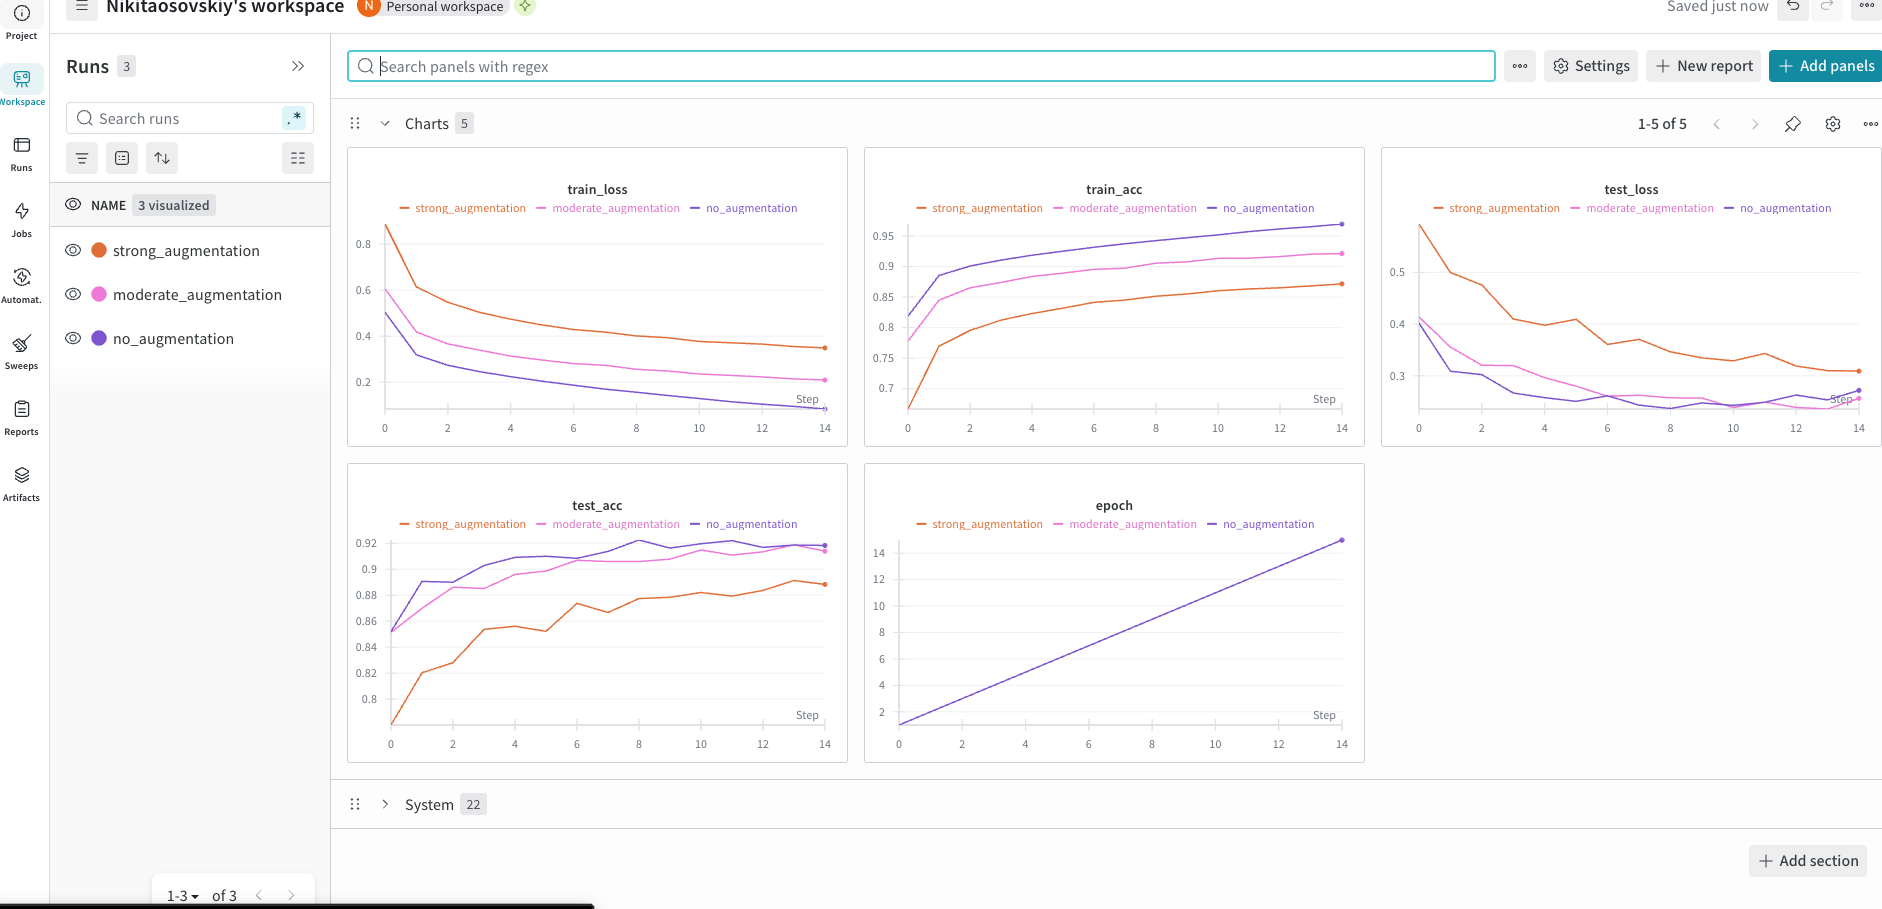